In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

Import the backtest results from Andreas Clenow's [website](https://www.followingthetrend.com/trading-evolved/)::

In [3]:
%%bash
cd /tmp
rm -rf trading_evolved
rm -f trading_evolved.zip

wget -q -O trading_evolved.zip trading_evolved.zip https://dl.dropbox.com/s/tj85sufbsi820ya/Trading%20Evolved.zip?dl=1
unzip -q -d trading_evolved trading_evolved.zip
ls -lah trading_evolved/Backtests

total 1.2M
drwxr-xr-x  2 root root 4.0K Jul 15  2019 .
drwxr-xr-x 20 root root 4.0K Nov 15 08:22 ..
-rw-r--r--  1 root root 165K Mar 27  2019 SPXTR.csv
-rw-r--r--  1 root root 202K Mar 27  2019 core_trend.csv
-rw-r--r--  1 root root 201K Mar 27  2019 counter_trend.csv
-rw-r--r--  1 root root 201K Mar 28  2019 curve_trading.csv
-rw-r--r--  1 root root 165K Mar 27  2019 equity_momentum.csv
-rw-r--r--  1 root root 201K Mar 27  2019 time_return.csv


<IPython.core.display.Javascript object>

In [4]:
DATA_FOLDER = "/tmp/trading_evolved"
base_path = f"{DATA_FOLDER}/Backtests/"

<IPython.core.display.Javascript object>

In [5]:
# Rebalance on percent divergence
class PercentRebalance(object):
    def __init__(self, percent_target):
        self.rebalance_count = 0
        self.percent_target = percent_target

    def rebalance(self, row, weights, date):
        total = row.sum()
        rebalanced = row
        rebalanced = np.multiply(total, weights)
        if np.any(
            np.abs((row - rebalanced) / rebalanced) > (self.percent_target / 100.0)
        ):
            self.rebalance_count = self.rebalance_count + 1
            return rebalanced
        else:
            return row

<IPython.core.display.Javascript object>

In [6]:
# Rebalance on calendar
class MonthRebalance(object):
    def __init__(self, months):
        self.month_to_rebalance = months
        self.rebalance_count = 0
        self.last_rebalance_month = 0

    def rebalance(self, row, weights, date):
        current_month = date.month

        if self.last_rebalance_month != current_month:
            total = row.sum()
            rebalanced = np.multiply(weights, total)
            self.rebalance_count = self.rebalance_count + 1
            self.last_rebalance_month = date.month
            return rebalanced
        else:
            return row

<IPython.core.display.Javascript object>

In [7]:
# Calculate the rebalanced combination
def calc_rebalanced_returns(returns, rebalancer, weights):
    returns = returns.copy() + 1

    # create a numpy ndarray to hold the cumulative returns
    cumulative = np.zeros(returns.shape)
    cumulative[0] = np.array(weights)

    # also convert returns to an ndarray for faster access
    rets = returns.values

    # using ndarrays all of the multiplicaion is now handled by numpy
    for i in range(1, len(cumulative)):
        np.multiply(cumulative[i - 1], rets[i], out=cumulative[i])
        cumulative[i] = rebalancer.rebalance(cumulative[i], weights, returns.index[i])

    # convert the cumulative returns back into a dataframe
    cumulativeDF = pd.DataFrame(
        cumulative, index=returns.index, columns=returns.columns
    )

    # finding out how many times rebalancing happens is an interesting exercise
    print("Rebalanced {} times".format(rebalancer.rebalance_count))

    # turn the cumulative values back into daily returns
    rr = cumulativeDF.pct_change() + 1
    rebalanced_return = rr.dot(weights) - 1
    return rebalanced_return

<IPython.core.display.Javascript object>

In [8]:
def get_strat(strat):
    df = pd.read_csv(
        base_path + strat + ".csv", index_col=0, parse_dates=True, names=[strat]
    )
    return df

<IPython.core.display.Javascript object>

In [9]:
# Use monthly rebalancer, one month interval
rebalancer = MonthRebalance(1)

# Define strategies and weights
portfolio = {
    'core_trend': 0.25,
    'counter_trend': 0.25,
    'curve_trading': 0.25,
    'time_return': 0.25,
}

# Read all the files into one DataFrame
df = pd.concat(
        [
            pd.read_csv('{}{}.csv'.format(
                        base_path,
                        strat
                        ), 
                        index_col=0,
                        parse_dates=True,
                        names=[strat]
                       ).pct_change().dropna()
            for strat in list(portfolio.keys())
        ], axis=1
)

# Calculate the combined portfolio
df['Combined'] = calc_rebalanced_returns(
    df, 
    rebalancer, 
    weights=list(portfolio.values())
    )

df.dropna(inplace=True)



Rebalanced 217 times


<IPython.core.display.Javascript object>

In [10]:
returns = df.copy()
returns.head(5)

,core_trend,counter_trend,curve_trading,time_return,Combined
2001-01-04,0.035684,0.004761,0.010680,0.021910,0.018259
2001-01-05,0.017619,0.008604,0.003265,0.014785,0.011068
2001-01-08,0.003766,0.001255,-0.002171,0.002880,0.001432
2001-01-09,-0.011515,0.000810,0.014165,0.002707,0.001542
2001-01-10,-0.014894,-0.002873,0.024707,0.003289,0.002557


<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
findfont: Font family ['eurostile'] not found. Falling back to DejaVu Sans.
findfont: Font family ['eurostile'] not found. Falling back to DejaVu Sans.


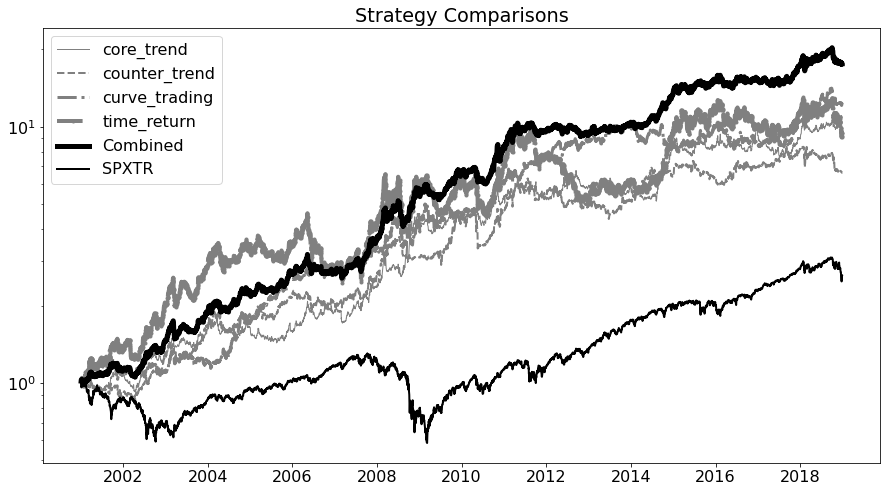

<IPython.core.display.Javascript object>

In [11]:
# Make Graph

include_combined = True
include_benchmark = True
benchmark = "SPXTR"

if include_benchmark:
    returns[benchmark] = get_strat(benchmark).pct_change()

normalized = (returns + 1).cumprod()

font = {"family": "eurostile", "weight": "normal", "size": 16}

matplotlib.rc("font", **font)


fig = plt.figure(figsize=(15, 8))

# First chart
ax = fig.add_subplot(111)
ax.set_title("Strategy Comparisons")

dashstyles = ["-", "--", "-.", ".-.", "-"]
i = 0
for strat in normalized:
    if strat == "Combined":
        if not include_combined:
            continue
        clr = "black"
        dash = "-"
        width = 5
    elif strat == benchmark:
        if not include_benchmark:
            continue
        clr = "black"
        dash = "-"
        width = 2
    # elif strat == 'equity_momentum':
    #    continue

    else:
        clr = "grey"
        dash = dashstyles[i]
        width = i + 1
        i += 1
    ax.semilogy(normalized[strat], dash, label=strat, color=clr, linewidth=width)

    ax.legend()